<a href="https://colab.research.google.com/github/HarshitJhawar/nifty-volatility-forecasting-with-lstm-garch/blob/main/GARCH_Volatility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U arch statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
total_df = pd.read_csv("/content/drive/MyDrive/Datasets /NIFTY 50_daily_data.csv")
total_df.head()

,date,open,high,low,close,volume
0,2015-01-01 00:00:00,8272.79,8294.70,8248.75,8284.0,0
1,2015-01-02 00:00:00,8288.70,8410.60,8288.70,8395.4,0
2,2015-01-05 00:00:00,8407.95,8445.60,8363.90,8378.4,0
3,2015-01-06 00:00:00,8325.29,8327.85,8111.35,8127.3,0
4,2015-01-07 00:00:00,8118.65,8151.20,8065.45,8102.1,0


In [ ]:
total_df = total_df.drop(["volume","open", "high", "low"], axis=1)
total_df['datetime'] = pd.to_datetime(total_df['date'])
# Split into two new columns
total_df['date'] = total_df['datetime'].dt.date
total_df['time'] = total_df['datetime'].dt.time
total_df = total_df.drop(["datetime", "time"], axis=1)
total_df.index = pd.to_datetime(total_df.index)
print(type(total_df.index))
total_df.set_index('date', inplace=True)
total_df.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,close
date,
2015-01-01,8284.0
2015-01-02,8395.4
2015-01-05,8378.4
2015-01-06,8127.3
2015-01-07,8102.1


In [ ]:
df = total_df.copy()
df['LogRet'] = np.log(df['close']).diff()
df.head()

,close,LogRet
date,,
2015-01-01,8284.0,NaN
2015-01-02,8395.4,0.013358
2015-01-05,8378.4,-0.002027
2015-01-06,8127.3,-0.030428
2015-01-07,8102.1,-0.003105


In [ ]:
df2 = df.iloc[1:].copy()
df2.head()

,close,LogRet
date,,
2015-01-02,8395.4,0.013358
2015-01-05,8378.4,-0.002027
2015-01-06,8127.3,-0.030428
2015-01-07,8102.1,-0.003105
2015-01-08,8234.6,0.016222


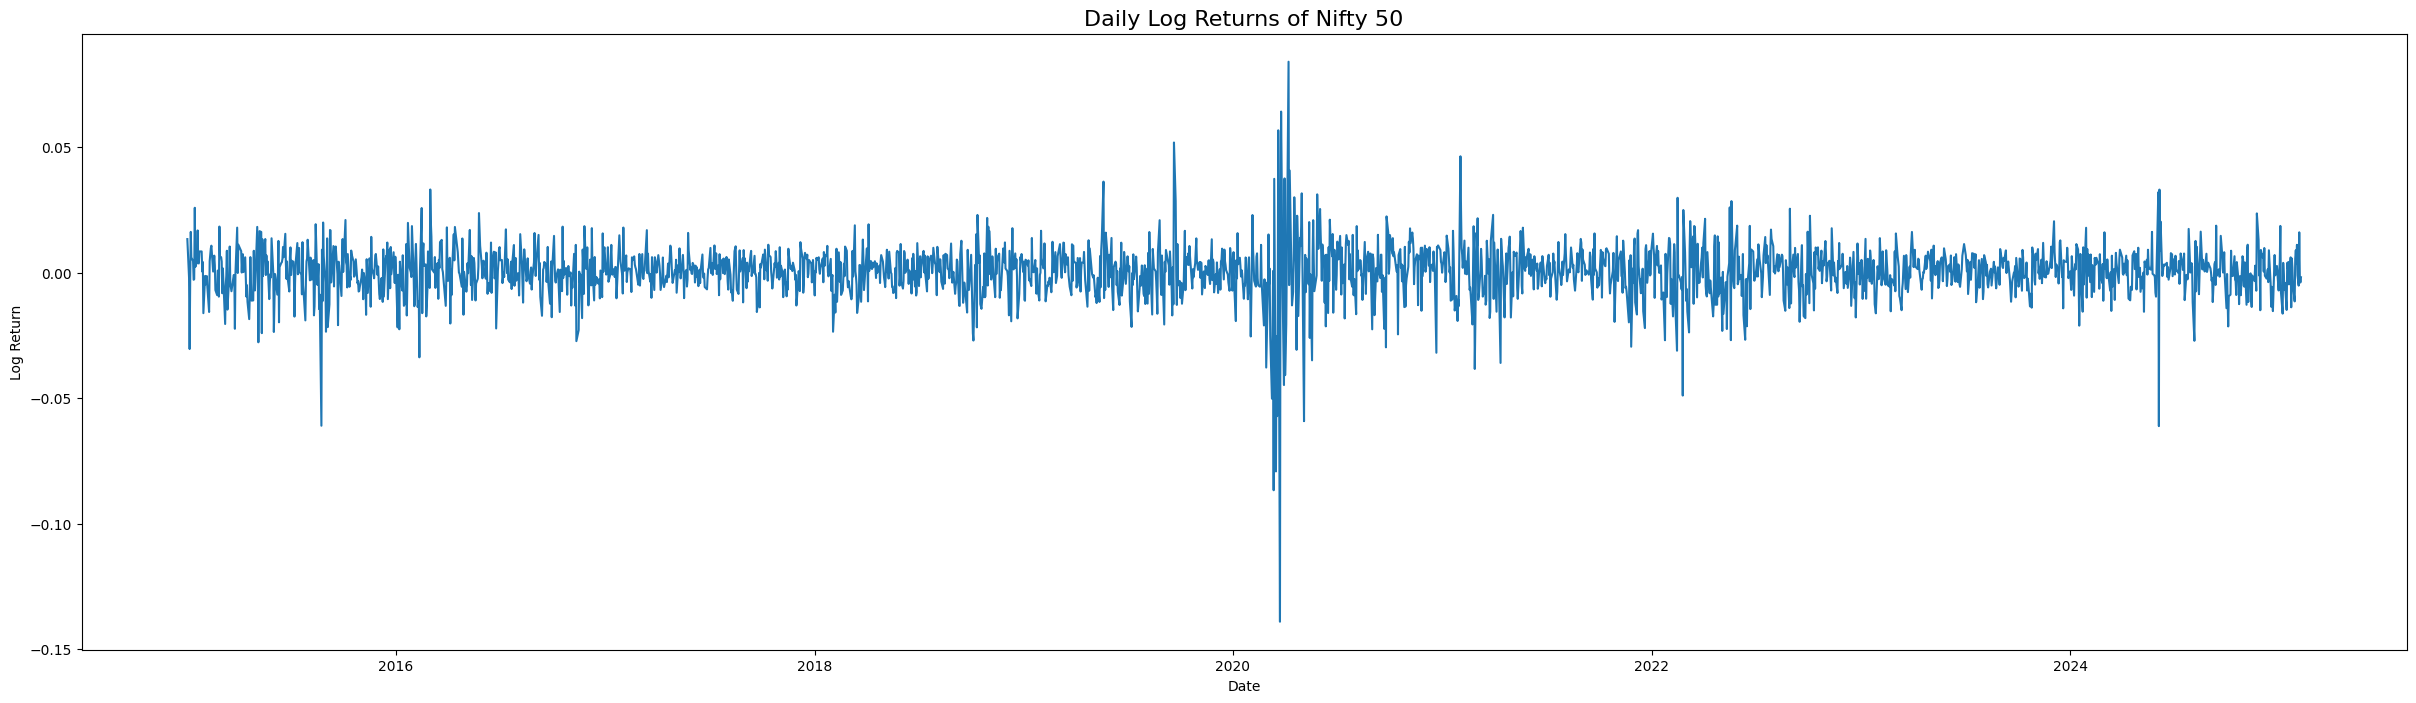

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(df2['LogRet'])
plt.title("Daily Log Returns of Nifty 50", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

The log returns are centered around zero, showing volatility clustering typical for financial time series.

<Axes: xlabel='date'>

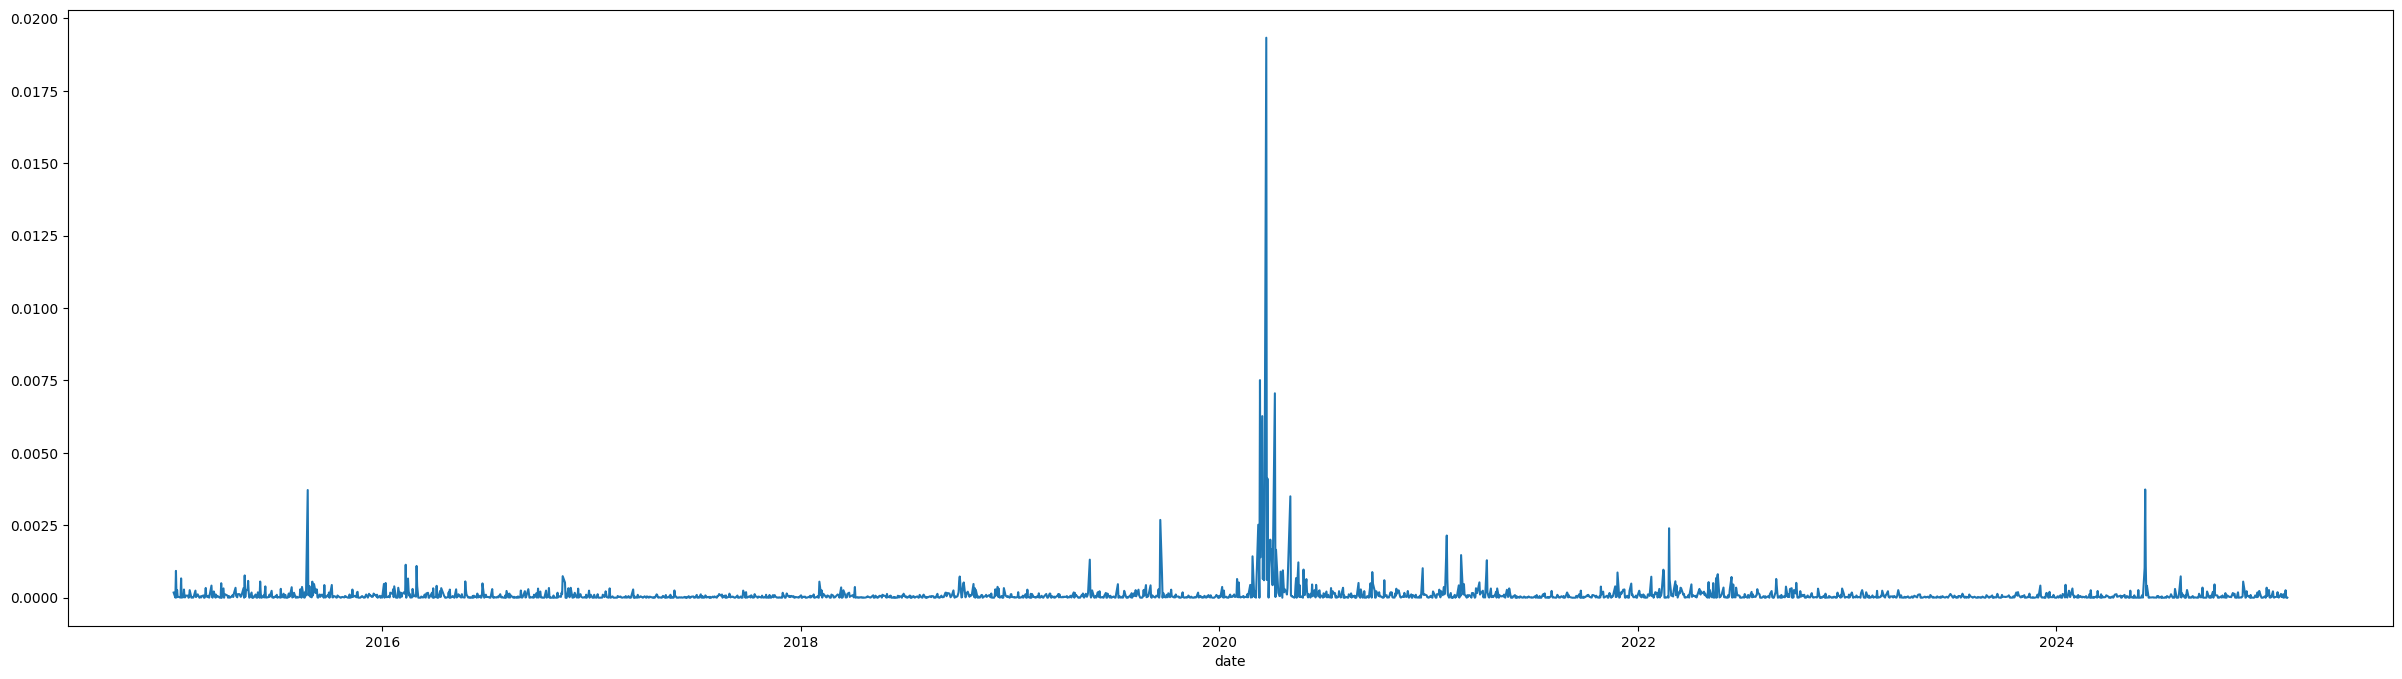

In [ ]:
df2['Ysq'] = df['LogRet'] ** 2
df2['Ysq'].plot(figsize = (30,8))

## 🔍 Autocorrelation Analysis (ACF & PACF)
- Here, we analyze **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** for:
  - Raw log returns
  - Squared log returns (to detect ARCH effects)
  
Significant spikes in squared returns indicate volatility clustering and justify GARCH modeling.

---

## 🔀 Train-Test Split
- Splitting dataset:
  - **Training set:** All points except last 500
  - **Test set:** Last 500 points
- Standardizing returns for stable modeling.


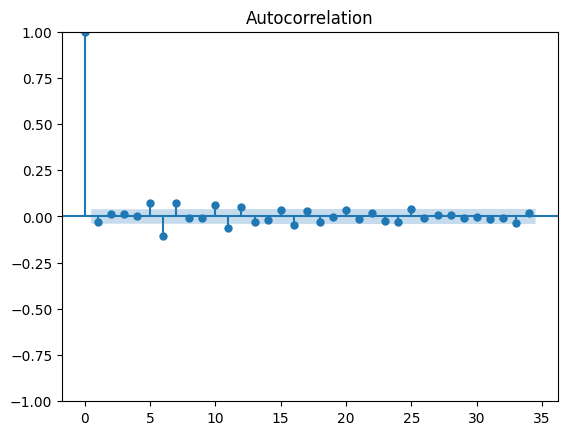

In [ ]:
plot_acf(df2['LogRet']);
# No significant correlations

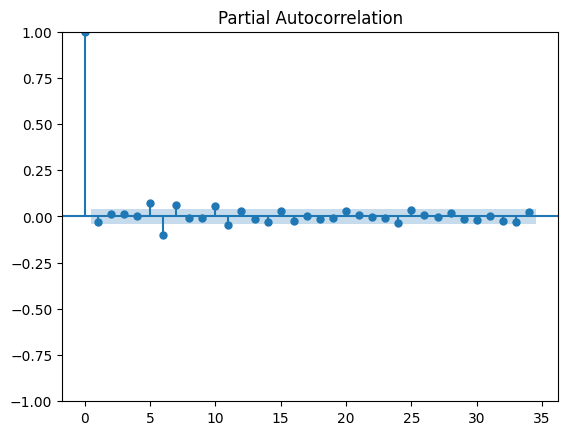

In [ ]:
plot_pacf(df2['LogRet']);

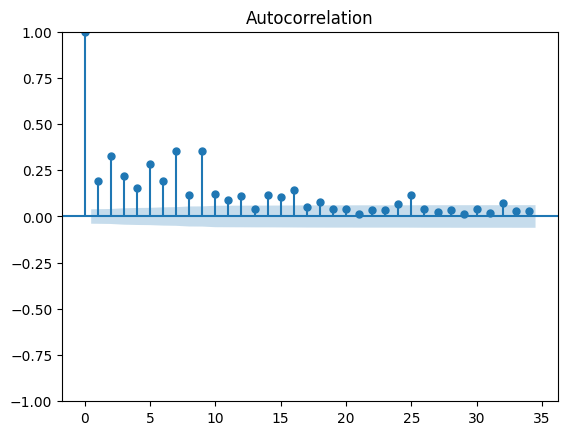

In [ ]:
plot_acf(df2['Ysq']);
# we can find significant correlations in ACF and PACF plots

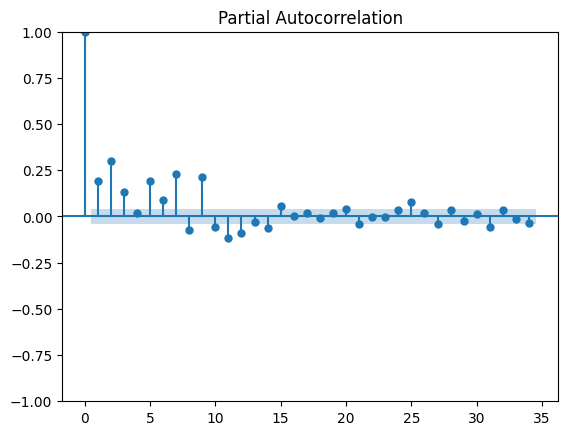

In [ ]:
plot_pacf(df2['Ysq']);

Train-Test Split

In [ ]:
no_test = 500
train = df2.iloc[:-no_test][['LogRet']].copy()
train.index = pd.to_datetime(train.index)
test = df2.iloc[-no_test:][['LogRet']].copy()

ARCH(1)

In [ ]:
mean = train['LogRet'].mean()
std = train['LogRet'].std()
train['scaled'] = (train['LogRet'] - mean) / std
test['scaled'] = (test['LogRet'] - mean) / std
df2['scaled'] = (df2['LogRet'] - mean) / std

In [ ]:
arch1 = arch_model(train['scaled'], vol = 'ARCH', p =1)
res_arch1 = arch1.fit(update_freq = 10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2667.512769817984
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6


In [ ]:
res_arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2667.51
Distribution:                  Normal   AIC:                           5341.03
Method:            Maximum Likelihood   BIC:                           5357.84
                                        No. Observations:                 2005
Date:                Mon, Jul 07 2025   Df Residuals:                     2004
Time:                        18:36:52   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0196  2.260e-02      0.866      0.386 [-2.472e-02,6.389e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6505  6.176e-02     10.532  6.126e-26 [  0.529,  0.772]
alpha[1]       0.3167  7.290e-02      4.344  1.397e-05 [  0.174,  0.460]
========================================================================

Covariance estimator: robust
"""

<Axes: xlabel='date'>

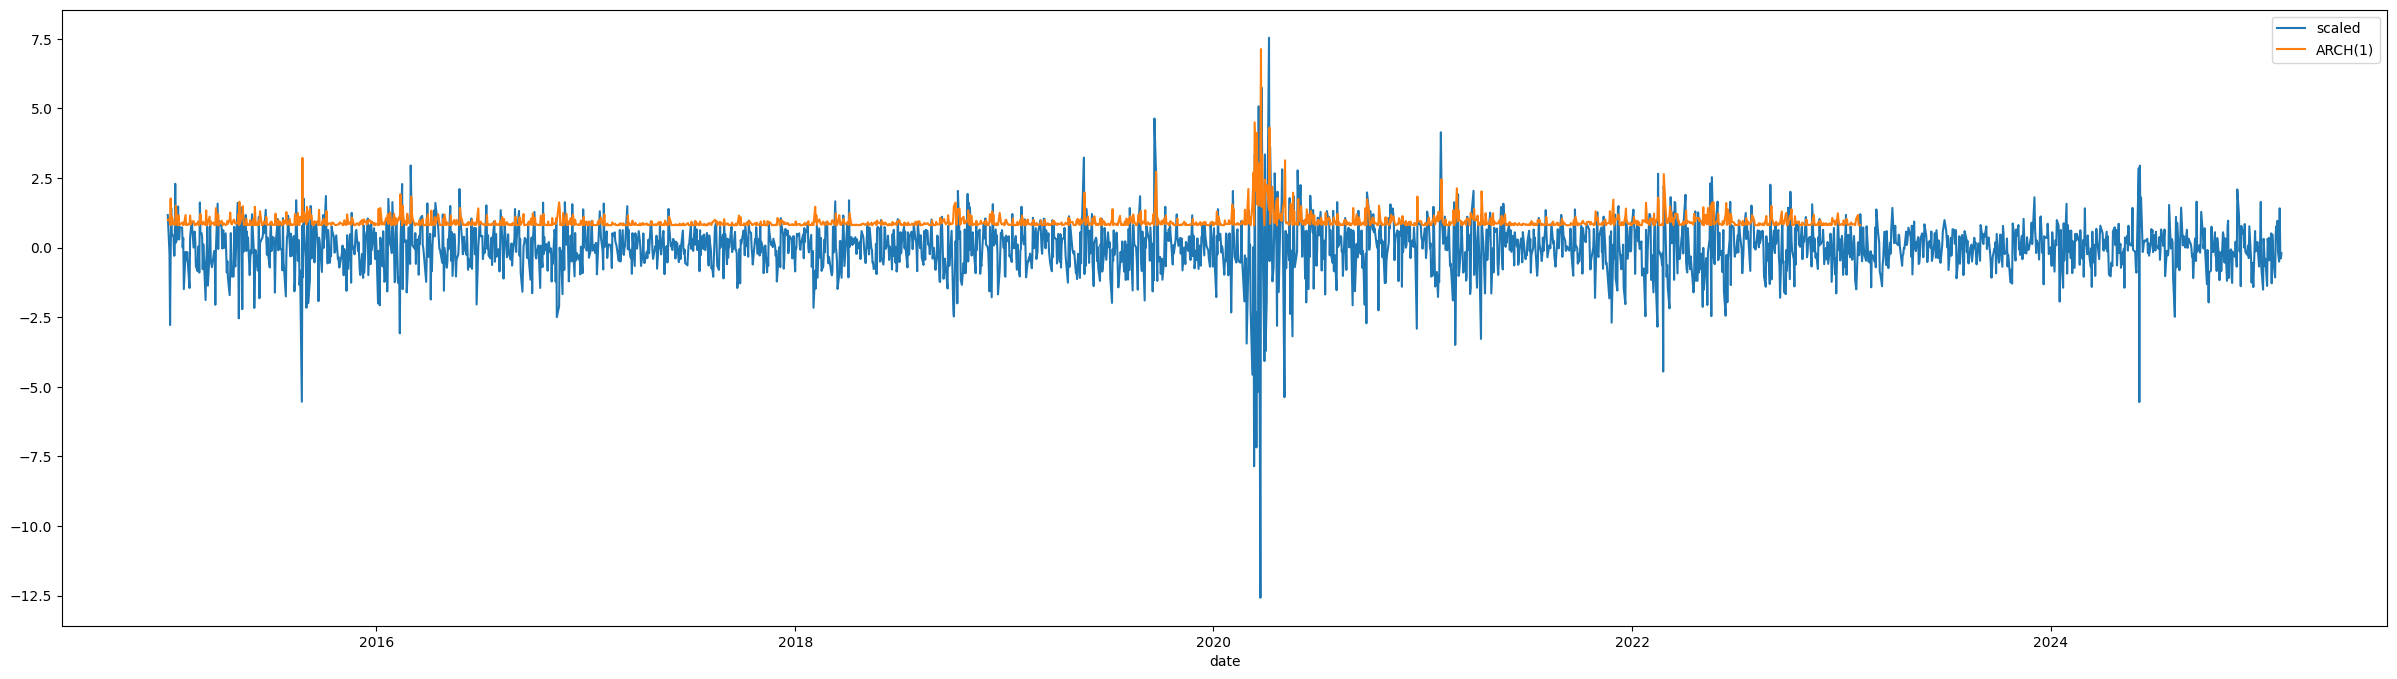

In [ ]:
df2['ARCH(1)'] = res_arch1.conditional_volatility
df2[['scaled', 'ARCH(1)']].plot(figsize = (30,8))

### ✅ Model Fit Check:
The fitted volatility visually tracks the high-volatility periods reasonably well.


In [ ]:
forecast_arch1.residual_variance  # same as variance due to the constant mean

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30,0.660078,0.859521,0.922682,0.942685,0.949020,0.951026,0.951661,0.951862,0.951926,0.951946,...,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956
2023-01-31,0.650536,0.856499,0.921725,0.942382,0.948924,0.950996,0.951652,0.951859,0.951925,0.951946,...,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956
2023-02-01,0.676853,0.864833,0.924365,0.943218,0.949188,0.951079,0.951678,0.951868,0.951928,0.951947,...,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956,0.951956


<Axes: xlabel='date'>

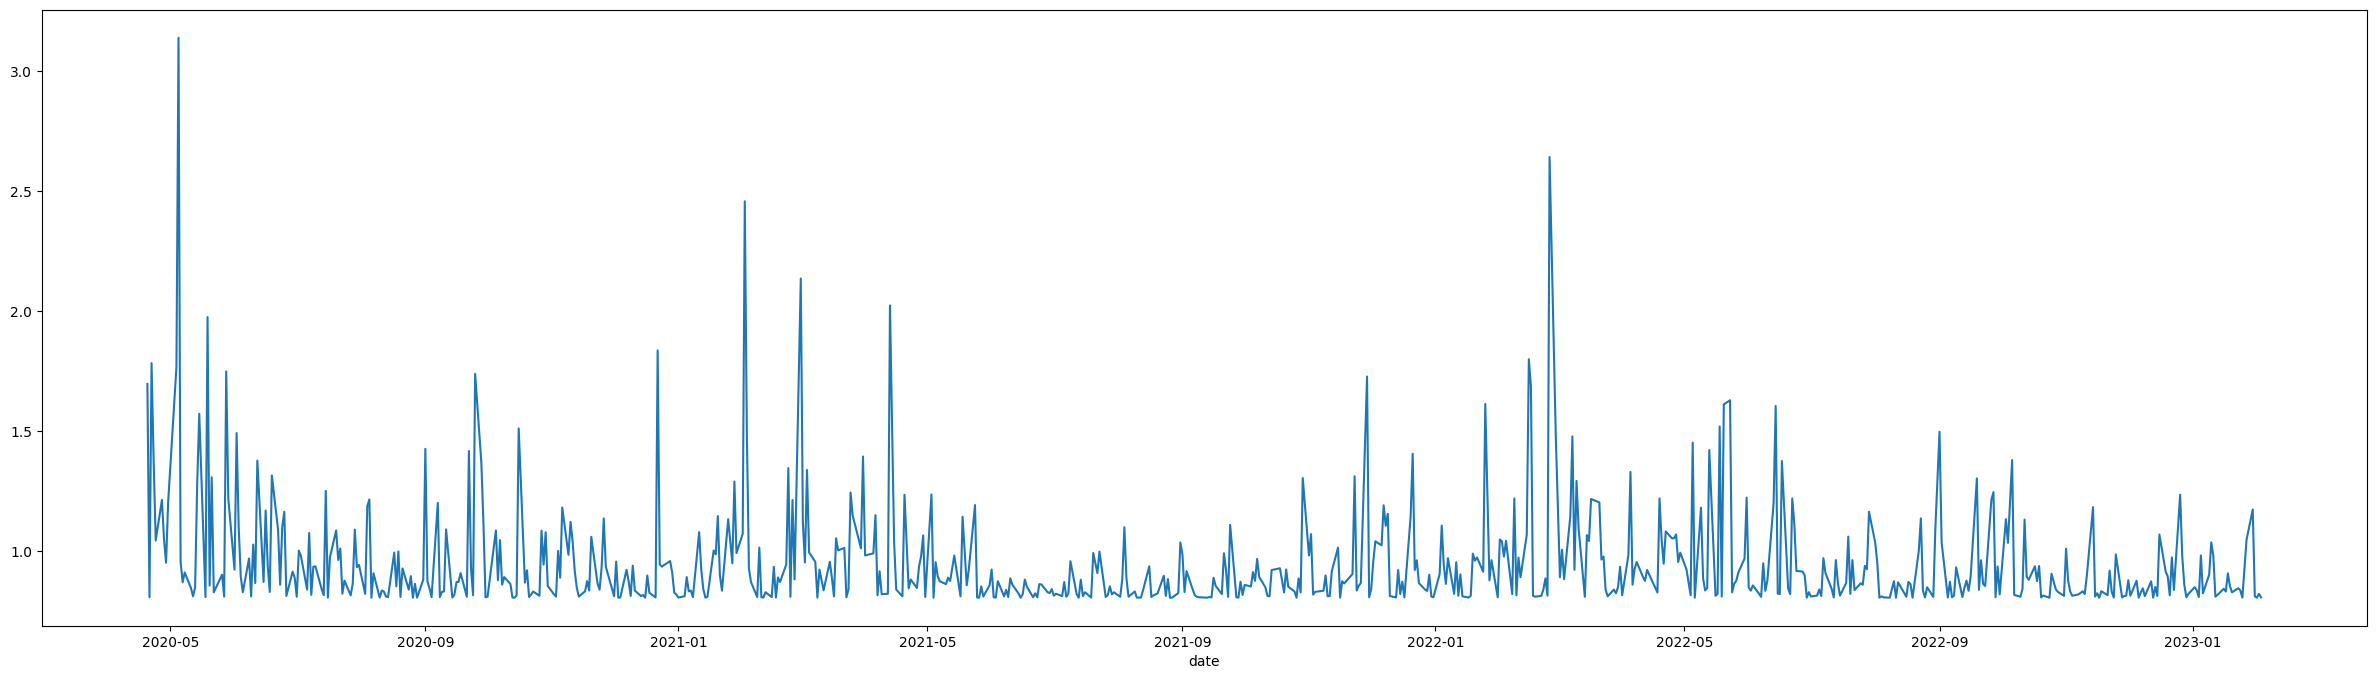

In [ ]:
import datetime
df2.loc[datetime.date(2020, 4, 20):]['ARCH(1)'].plot(figsize = (30,8))

In [ ]:
forecast_arch1 = res_arch1.forecast(
    horizon = no_test,
    reindex = True,
    start = '2020-04-20'
)

In [ ]:
df2.index = pd.to_datetime(df2.index)
df2.index.get_loc('2020-04-20')

1306

In [ ]:
df2.loc['2020-04-20':'2022-04-20', 'ARCH(1) Forecast'] = np.sqrt(
    forecast_arch1.residual_variance.loc['2020-04-20'].to_numpy())

In [ ]:
df.index[1806]

datetime.date(2022, 4, 20)

In [ ]:
res_arch1.params

,params
mu,0.019583
omega,0.650480
alpha[1],0.316691


We see that after 10 forecasts, the values of forecasts to the unconditional variance

GARCH (1,1) - We can also that GARCH(1,1) has improved performance metrics of AIC and BIC than ARCH(1)

In [ ]:
garch11 = arch_model(train['scaled'], vol = 'GARCH', p = 1, q = 1)
res_garch11 = garch11.fit(update_freq=10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2480.020392380471
            Iterations: 6
            Function evaluations: 42
            Gradient evaluations: 6


In [ ]:
res_garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2480.02
Distribution:                  Normal   AIC:                           4968.04
Method:            Maximum Likelihood   BIC:                           4990.45
                                        No. Observations:                 2005
Date:                Mon, Jul 07 2025   Df Residuals:                     2004
Time:                        18:36:58   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0303  1.777e-02      1.707  8.788e-02 [-4.501e-03,6.515e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0198  5.825e-03      3.391  6.957e-04 [8.337e-03,3.117e-02]
alpha[1]       0.0993  1.881e-02      5.282  1.278e-07   [6.248e-02,  0.136]
beta[1]        0.8793  1.771e-02     49.662      0.000     [  0.845,  0.914]
============================================================================

Covariance estimator: robust
"""

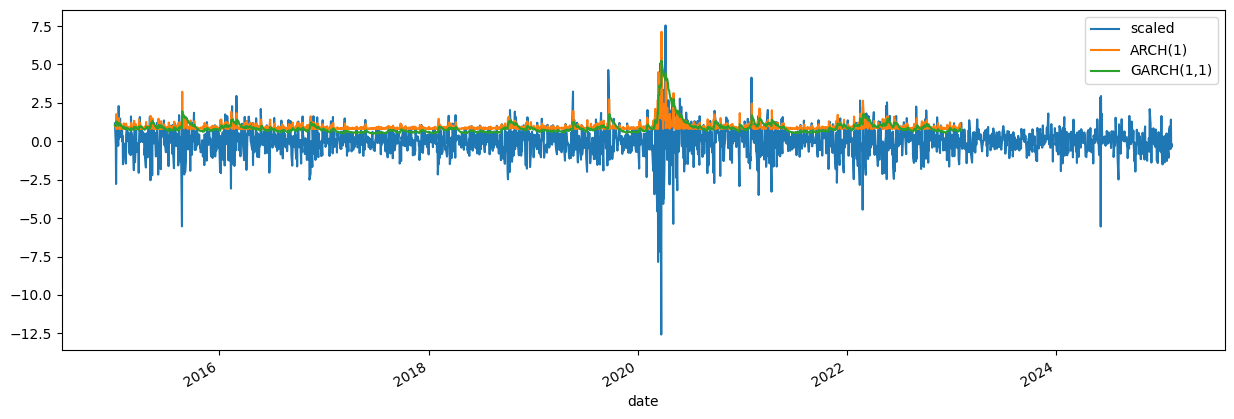

In [ ]:
df2['GARCH(1,1)'] = res_garch11.conditional_volatility
df2[['scaled', 'ARCH(1)', 'GARCH(1,1)']].plot(figsize=(15, 5));

In [ ]:
forecast_garch11 = res_garch11.forecast(
    horizon=no_test, reindex=False, start='2020-04-20')

In [ ]:
df2.loc['2020-04-20':'2022-04-20', 'GARCH(1,1) Forecast'] = np.sqrt(
    forecast_garch11.residual_variance.loc['2020-04-20'].to_numpy())
df2

,close,LogRet,Ysq,scaled,ARCH(1),ARCH(1) Forecast,"GARCH(1,1)","GARCH(1,1) Forecast"
date,,,,,,,,
2015-01-02,8395.40,0.013358,0.000178,1.170305,0.998539,NaN,1.044438,NaN
2015-01-05,8378.40,-0.002027,0.000004,-0.217371,1.034326,NaN,1.052648,NaN
2015-01-06,8127.30,-0.030428,0.000926,-2.779074,0.817472,NaN,1.000096,NaN
2015-01-07,8102.10,-0.003105,0.000010,-0.314649,1.769452,NaN,1.297452,NaN
2015-01-08,8234.60,0.016222,0.000263,1.428584,0.828165,NaN,1.229555,NaN
...,...,...,...,...,...,...,...,...
2025-02-03,23361.05,-0.005170,0.000027,-0.500904,NaN,NaN,NaN,NaN
2025-02-04,23739.25,0.016060,0.000258,1.413989,NaN,NaN,NaN,NaN
2025-02-05,23696.30,-0.001811,0.000003,-0.197881,NaN,NaN,NaN,NaN


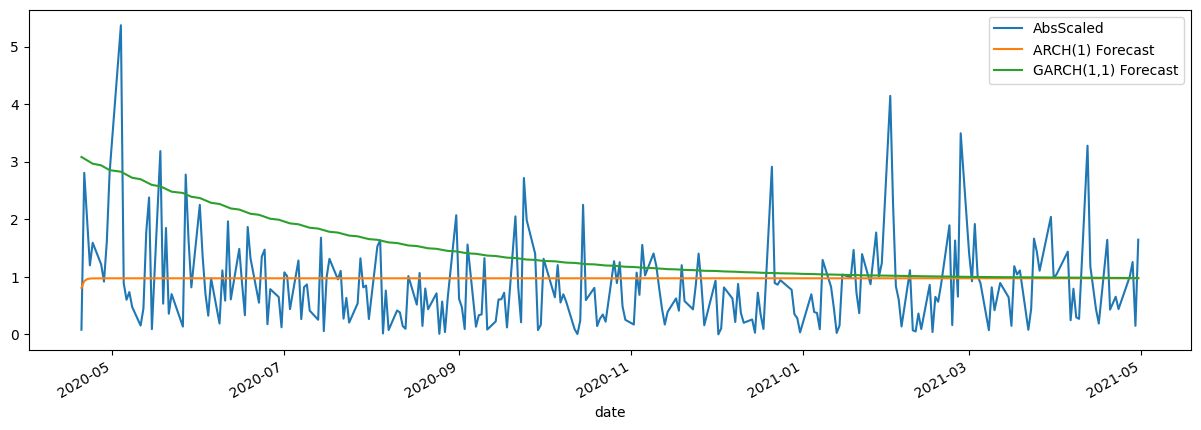

In [ ]:
df2['AbsScaled'] = df2['scaled'].abs()

plot_cols = ['AbsScaled', 'ARCH(1) Forecast', 'GARCH(1,1) Forecast']
df2.loc['2020-04-20':'2021-04-30'][plot_cols].plot(figsize=(15, 5));

It has been observed that stock returns distributions are explained better by Students-t distribution rather than Normal distribution

In [ ]:
garch11t = arch_model(train['scaled'], vol='GARCH', p=1, q=1, dist='StudentsT')

In [ ]:
res_garch11t = garch11t.fit(update_freq=10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 2431.704360075146
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2431.704360075146
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11


In [ ]:
res_garch11t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2431.70
Distribution:      Standardized Student's t   AIC:                           4873.41
Method:                  Maximum Likelihood   BIC:                           4901.43
                                              No. Observations:                 2005
Date:                      Mon, Jul 07 2025   Df Residuals:                     2004
Time:                              18:37:05   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0417  1.656e-02      2.516  1.186e-02 [9.211e-03,7.412e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0207  5.481e-03      3.783  1.550e-04 [9.992e-03,3.148e-02]
alpha[1]       0.0803  1.370e-02      5.864  4.522e-09   [5.346e-02,  0.107]
beta[1]        0.8934  1.529e-02     58.424      0.000     [  0.863,  0.923]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.6909      0.944      7.088  1.357e-12 [  4.841,  8.541]
========================================================================

Covariance estimator: robust
"""

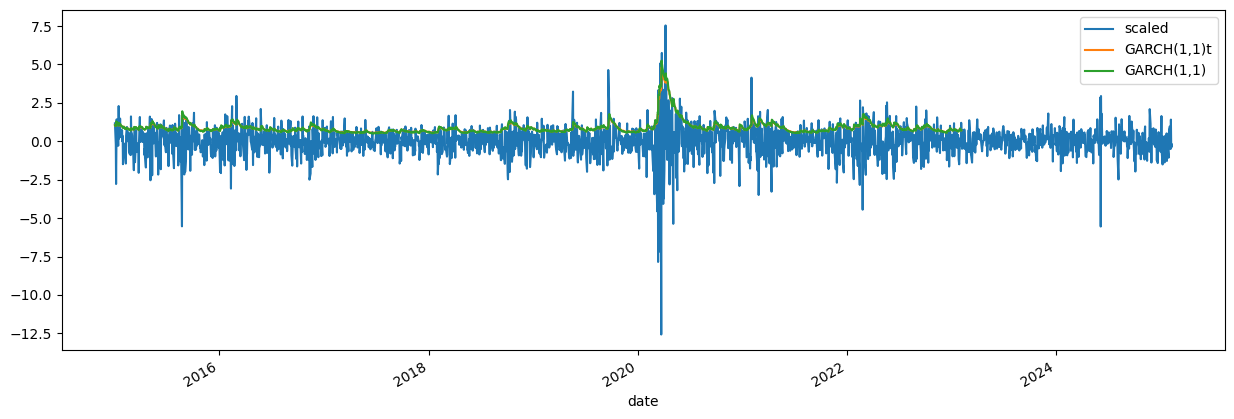

In [ ]:
df2['GARCH(1,1)t'] = res_garch11t.conditional_volatility
df2[['scaled', 'GARCH(1,1)t', 'GARCH(1,1)']].plot(figsize=(15, 5));

In [ ]:
forecast_garch11t = res_garch11t.forecast(
    horizon=no_test, reindex=False, start='2020-04-20')

In [ ]:
df2.loc['2020-04-20':'2022-04-20', 'GARCH(1,1)t Forecast'] = np.sqrt(
    forecast_garch11t.residual_variance.loc['2020-04-20'].to_numpy())

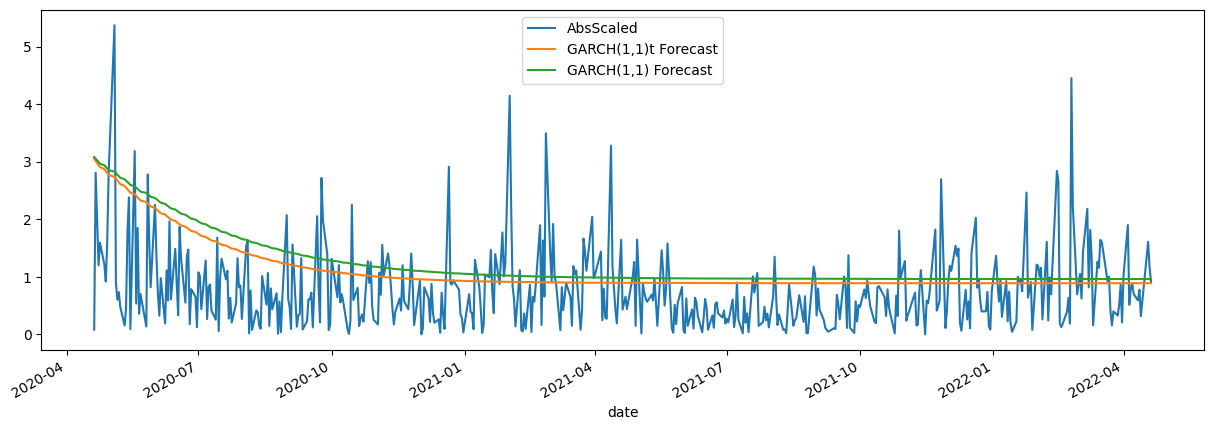

In [ ]:
plot_cols = ['AbsScaled', 'GARCH(1,1)t Forecast', 'GARCH(1,1) Forecast']
df2.loc['2020-04-20':'2022-04-20'][plot_cols].plot(figsize=(15, 5));

GARCH(p, q)

In [ ]:
garchpq = arch_model(train['scaled'], p=8, q=5, dist='StudentsT')
res_garchpq = garchpq.fit(update_freq=10)

Iteration:     10,   Func. Count:    189,   Neg. LLF: 2445.3031981897075
Iteration:     20,   Func. Count:    363,   Neg. LLF: 2429.9422237737904
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2429.9419681652334
            Iterations: 24
            Function evaluations: 419
            Gradient evaluations: 23


In [ ]:
res_garchpq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2429.94
Distribution:      Standardized Student's t   AIC:                           4891.88
Method:                  Maximum Likelihood   BIC:                           4981.54
                                              No. Observations:                 2005
Date:                      Mon, Jul 07 2025   Df Residuals:                     2004
Time:                              18:37:10   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0406  1.669e-02      2.435  1.489e-02 [7.930e-03,7.337e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0674  2.614e-02      2.578  9.945e-03    [1.615e-02,  0.119]
alpha[1]       0.0785  2.912e-02      2.696  7.014e-03    [2.143e-02,  0.136]
alpha[2]       0.0574  4.638e-02      1.238      0.216   [-3.347e-02,  0.148]
alpha[3]       0.0377  4.422e-02      0.852      0.394   [-4.901e-02,  0.124]
alpha[4]       0.0838  4.965e-02      1.688  9.139e-02   [-1.350e-02,  0.181]
alpha[5]   1.4684e-17  4.551e-02  3.227e-16      1.000 [-8.919e-02,8.919e-02]
alpha[6]   5.9732e-18  4.525e-02  1.320e-16      1.000 [-8.868e-02,8.868e-02]
alpha[7]   7.7983e-17  5.266e-02  1.481e-15      1.000      [ -0.103,  0.103]
alpha[8]   8.2876e-03  3.454e-02      0.240      0.810 [-5.942e-02,7.599e-02]
beta[1]        0.2315      0.435      0.532      0.595      [ -0.622,  1.085]
beta[2]    5.7554e-18      0.429  1.342e-17      1.000      [ -0.841,  0.841]
beta[3]    1.0028e-17      0.306  3.282e-17      1.000      [ -0.599,  0.599]
beta[4]    1.2776e-17      0.290  4.412e-17      1.000      [ -0.568,  0.568]
beta[5]        0.4183      0.216      1.940  5.243e-02   [-4.387e-03,  0.841]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.7200      0.954      7.042  1.889e-12 [  4.850,  8.590]
========================================================================

Covariance estimator: robust
"""

In [ ]:
res_arch1.aic, res_garch11.aic, res_garch11t.aic, res_garchpq.aic

(5341.025539635968, 4968.040784760942, 4873.408720150292, 4891.883936330467)

## Exploring Higher-Order GARCH(p, q) Models
We compare score of multiple GARCH models using the AIC metric

In [ ]:
import numpy as np
aic_scores = {}
for p in range(1, 6):
  for q in range(1, 6):
    try:
      garch_model = arch_model(train['scaled'], p=p, q=q, dist='StudentsT')
      res = garch_model.fit(disp='off')  # Turn off verbose output
      aic_scores[(p, q)] = res.aic
    except:
      # Handle potential convergence issues or errors
      aic_scores[(p, q)] = np.inf

# Sort AIC scores in ascending order
sorted_aic = sorted(aic_scores.items(), key=lambda item: item[1])

print("GARCH(p,q) AIC Scores (Ascending Order):")
for (p, q), aic in sorted_aic:
  print(f"GARCH({p},{q}): {aic:.4f}")

GARCH(p,q) AIC Scores (Ascending Order):
GARCH(1,1): 4873.4087
GARCH(2,1): 4875.3993
GARCH(1,2): 4875.4087
GARCH(2,2): 4876.8363
GARCH(1,3): 4877.3675
GARCH(3,1): 4877.3993
GARCH(2,3): 4878.3333
GARCH(3,2): 4878.8363
GARCH(1,4): 4879.3675
GARCH(4,1): 4879.3993
GARCH(2,4): 4880.3333
GARCH(3,3): 4880.3333
GARCH(4,2): 4880.8260
GARCH(1,5): 4881.2632
GARCH(5,1): 4881.3993
GARCH(2,5): 4881.8187
GARCH(4,3): 4882.1973
GARCH(3,4): 4882.3333
GARCH(5,2): 4882.8260
GARCH(4,5): 4883.9347
GARCH(5,3): 4884.1973
GARCH(4,4): 4884.5788
GARCH(3,5): 4884.5919
GARCH(5,5): 4885.9347
GARCH(5,4): 4886.5788


We can observe here that GARCH(1,1) has performed better than all of the other models here  

In [ ]:
train_idx = df2.index <= train.index[-1]
test_idx = ~train_idx

In [ ]:
df2.loc[train_idx, 'GARCH(1,1) Train'] = res_garch11.conditional_volatility
df2.loc[test_idx, 'GARCH(1,1) Test'] = np.sqrt(
    forecast_garch11.variance.iloc[-1].to_numpy())

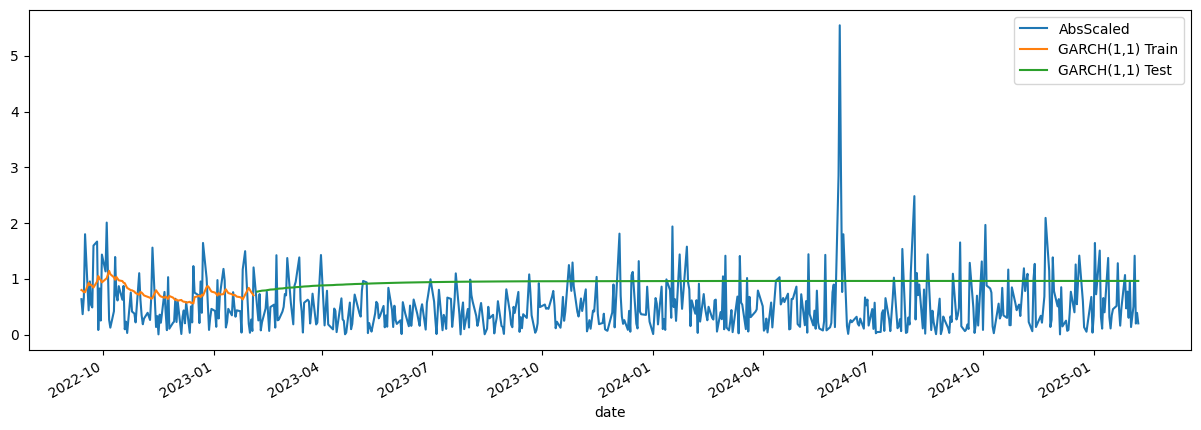

In [ ]:
plot_cols = ['AbsScaled', 'GARCH(1,1) Train', 'GARCH(1,1) Test']
df2.iloc[-(no_test+100):][plot_cols].plot(figsize=(15, 5));